# Lesson 05
# Peter Lorenz

## <font color='red'>IMPORTANT!!!</font>
<font color='red'>**Please customize to correct local path before running this notebook:**</font>

In [111]:
# IMPORTANT: Set GRAPHVIZ_PATH to correct local path!
GRAPHVIZ_PATH = 'C:/Users/Pete/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin/graphviz'

## 0. Preliminaries

Import the required libraries:

In [108]:
import matplotlib as mpl
import numpy as np
import os
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Declare utility functions:

In [110]:
# Display decision tree using graphviz
def show_tree(out_name, model, feature_names):
    dotfile = open(out_name + ".dot", 'w')
    tree.export_graphviz(model, out_file = dotfile, filled = True, rounded = True, feature_names = feature_names)
    dotfile.close()

    os.environ["PATH"] += os.pathsep + GRAPHVIZ_PATH
    os.system('dot -Tpng {}.dot -o {}.png'.format(out_name, out_name))

    return(Image(filename = out_name + '.png', width = 500, height = 500))

## Read (and clean) data
First we import the data set:

In [48]:
# Internet location of the data set
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

# Download the data into a dataframe object
cancer_data = pd.read_csv(url, comment='#')

cancer_data.columns = ['ID', 'Clump Thickness', 
                       'Uniformity of Cell Size', 'Uniformity of Cell Shape', 
                       'Marginal Adhesion', 'Single Epithelial Cell Size', 
                       'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 
                       'Mitosis', 'Class']

# Display shape and initial data
cancer_data.shape
cancer_data.head()

# Examine column types
cancer_data.info()

(698, 11)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           698 non-null    int64 
 1   Clump Thickness              698 non-null    int64 
 2   Uniformity of Cell Size      698 non-null    int64 
 3   Uniformity of Cell Shape     698 non-null    int64 
 4   Marginal Adhesion            698 non-null    int64 
 5   Single Epithelial Cell Size  698 non-null    int64 
 6   Bare Nuclei                  698 non-null    object
 7   Bland Chromatin              698 non-null    int64 
 8   Normal Nucleoli              698 non-null    int64 
 9   Mitosis                      698 non-null    int64 
 10  Class                        698 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


The 'Bare Nuclei' column appears to be a string due to having missing values encoded as question marks. So we replace the missing values with the column median and convert the column to int:

In [49]:
# Impute missing values using column median
cancer_data = cancer_data.replace('?', np.NaN)
cancer_data = cancer_data.apply(lambda x: x.fillna(x.median()))

# Convert column to integer
cancer_data['Bare Nuclei'] = np.array(cancer_data['Bare Nuclei']).astype(int)

Next we prepare the data set for modeling by removing and setting aside the 'ID' column:

In [50]:
# Extract and reserve the ID column
id_values = np.array(cancer_data['ID'].values)
cancer_data = cancer_data.drop(['ID'], axis=1)

Now extract the 'Class' column as the target variable and encode malignant as '1' and benign as '0':

In [51]:
# Extract and encode target variable
is_malignant = np.array([cancer_data['Class'] == 4]).astype(int)
is_malignant = is_malignant[0]

# Remove class from the data set
cancer_data = cancer_data.drop(['Class'], axis=1)

Our data is now ready to model.

## 1. Test both entropy and the gini coefficient
In this section we test entropy and the gini coefficient to answer the question which performs better and why. First we partition our data set into training and test:

In [54]:
# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(cancer_data, 
                                                    is_malignant, 
                                                    test_size = 0.1, 
                                                    random_state = 99)

Next we build a model using a decision tree classifier using the entropy coefficient:

In [73]:
# Construct decision tree classifier
cancer_ent = DecisionTreeClassifier(criterion = 'entropy')
cancer_ent.fit(X_train, y_train)

# Display tree depth
print('Max depth:', cancer_ent.tree_.max_depth)

# Predict based on test data
y_pred_test_ent = cancer_ent.predict(X_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Max depth: 9


Examine the confusion matrix and performance metrics for entropy:

In [66]:
# Display confusion matrix
confusion_matrix(y_test, y_pred_test_ent)

# Display performance metrics
print(classification_report(y_test, y_pred_test_ent))

array([[52,  2],
       [ 2, 14]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.88      0.88      0.88        16

    accuracy                           0.94        70
   macro avg       0.92      0.92      0.92        70
weighted avg       0.94      0.94      0.94        70



We also build a model using a decision tree classifier with the gini coefficient:

In [72]:
# Construct decision tree classifier
cancer_gin = DecisionTreeClassifier(criterion = 'gini')
cancer_gin.fit(X_train, y_train)

# Display tree depth
print('Max depth:', cancer_gin.tree_.max_depth)

# Predict based on test data
y_pred_test_gin = cancer_gin.predict(X_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Max depth: 10


Examine the confusion matrix and performance metrics for gini:

In [68]:
# Display confusion matrix
confusion_matrix(y_test, y_pred_test_gin)

# Display performance metrics
print(classification_report(y_test, y_pred_test_gin))

array([[52,  2],
       [ 1, 15]], dtype=int64)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.88      0.94      0.91        16

    accuracy                           0.96        70
   macro avg       0.93      0.95      0.94        70
weighted avg       0.96      0.96      0.96        70



Using the available performance metrics, the entropy method performs the same as the gini method in precision of identifying malignant cases (both = 0.88), but the gini method outperforms the entropy method on recall in identifying malignant cases (0.94 to 0.88). For cases of malignant cancer, we want to err on the side of having some false positives that end up not being malignant rather than potentially missing a case of malignant cancer. For this reason, the gini method, with its higher recall, is preferrable because more malignant cases were successfully identified, though at the cost of some additional false positives.

## 2. Find best hyperparameter settings
In this section we find the best hyperparameter settings for methods using entropy and the gini coefficient, focusing on the the 'max_depth' hyperparameter. To accomplish this, we use the GridSearchCV method, first with the entropy method:

In [97]:
tree_preds_ent

array([0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 1.   ,
       0.318, 0.   , 1.   , 0.   , 0.893, 0.   , 0.   , 0.893, 0.   ,
       0.   , 0.   , 0.893, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.893, 0.   , 0.   , 0.   , 0.   ,
       0.893, 0.318, 0.   , 0.   , 0.   , 0.818, 0.893, 0.   , 0.893,
       0.   , 0.   , 1.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 1.   , 0.   , 1.   , 0.   , 0.   , 0.   ,
       0.   , 0.318, 0.   , 0.318, 0.   , 0.   , 0.   ])

In [99]:
# Range of values to test (both methods)
param_grid = {'max_depth': np.arange(3, 12)}

# Search trees under specified range of values
tree_ent = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy', 
                                               random_state=0), 
                        param_grid)

# Fit model under optimal parameters
tree_ent.fit(X_train, y_train)
tree_pred_ent = tree_ent.predict(X_test)

# Display optimal parameters
print('Optimal max depth: ', tree_ent.best_params_['max_depth'])

# Display confusion matrix with optimal parameters
confusion_matrix(y_test, tree_pred_ent)

# Display performance metrics with optimal parameters
print(classification_report(y_test, tree_pred_ent))

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])},
             pre_dispatch='2*n_jobs',

Optimal max depth:  3


array([[53,  1],
       [ 2, 14]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.93      0.88      0.90        16

    accuracy                           0.96        70
   macro avg       0.95      0.93      0.94        70
weighted avg       0.96      0.96      0.96        70



For the entropy method, the optimal max depth is 3 (with random_state = 0). (Note: other values of random_state yield an optimal max depth of 4.)

We now apply GridSearchCV to the gini method:

In [107]:
# Search trees under specified range of values
tree_gin = GridSearchCV(DecisionTreeClassifier(criterion = 'gini', 
                                               random_state=0), 
                        param_grid)

# Fit model under optimal parameters
tree_gin.fit(X_train, y_train)
tree_pred_gin = tree_gin.predict(X_test)
tree_perf_gin = roc_auc_score(y_test, tree_preds_gin)

# Display optimal parameters
print('Optimal max depth: ', tree_gin.best_params_['max_depth'])

# Display confusion matrix with optimal parameters
confusion_matrix(y_test, tree_pred_gin)

# Display performance metrics with optimal parameters
print(classification_report(y_test, tree_pred_gin))

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10

Optimal max depth:  4


array([[52,  2],
       [ 0, 16]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        54
           1       0.89      1.00      0.94        16

    accuracy                           0.97        70
   macro avg       0.94      0.98      0.96        70
weighted avg       0.97      0.97      0.97        70



For the gini method, the optimal max depth is 4 (with random_state = 0). (Note: other values of random_state also seem to yield an optimal max depth of 4, suggesting that this method is generally more stable.)

When we compare the entropy and gini methods using optimal parameters, the superior performance of the gini method becomes even more clear, with perfect recall of 1.0. On the other hand, the recall of the entropy method remains unchanged at 0.88.

## 3. Visualize both models and see which feature is selected for each criterion
In this section we visualize both models and see which feature is selected for each criterion. Our goal is to determine whether the same feature is selected for both models and ascertain the reason behind this. We begin with the 'entropy' tree using the optimal hyperparameters identified above:

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

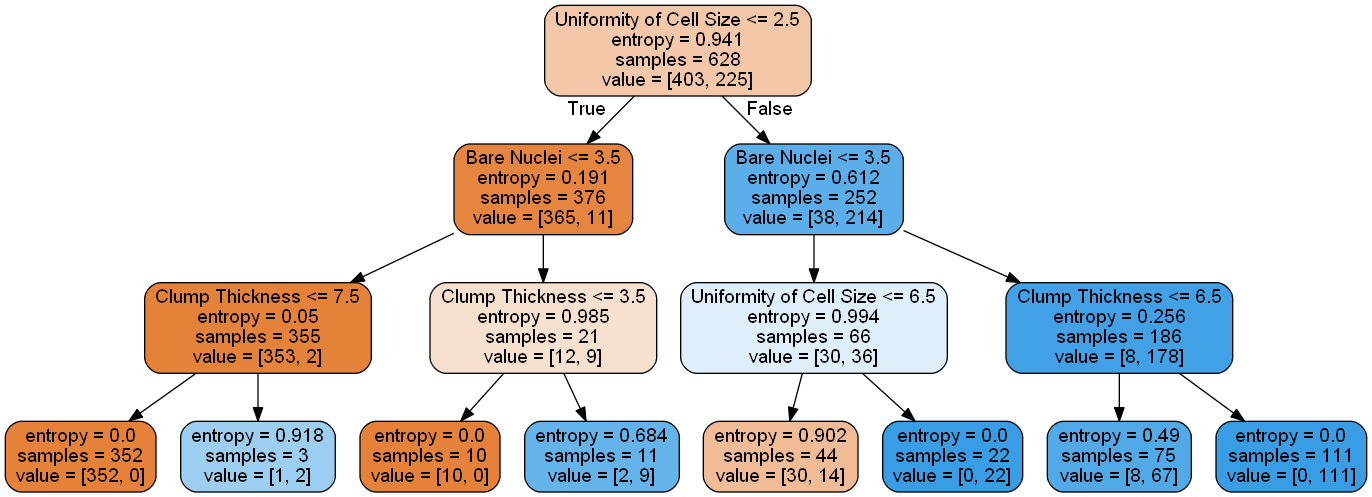

In [115]:
# Build and fit tree again using optimal hyperparameters
cancer_ent = DecisionTreeClassifier(criterion = 'entropy',
                                    max_depth = 3)
cancer_ent.fit(X_train, y_train)

# Display tree
show_tree('entropy_tree', cancer_ent, X_train.columns)

The entropy method selects features in the order:

1. Criterion 1: 'Uniformity of Cell Size'
1. Criterion 2: 'Bare Nuclei'
1. Criterion 3: 'Clump Thickness' or 'Uniformity of Cell Size'

We now visualize the 'gini' tree using the above identified optimal hyperparameters:

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

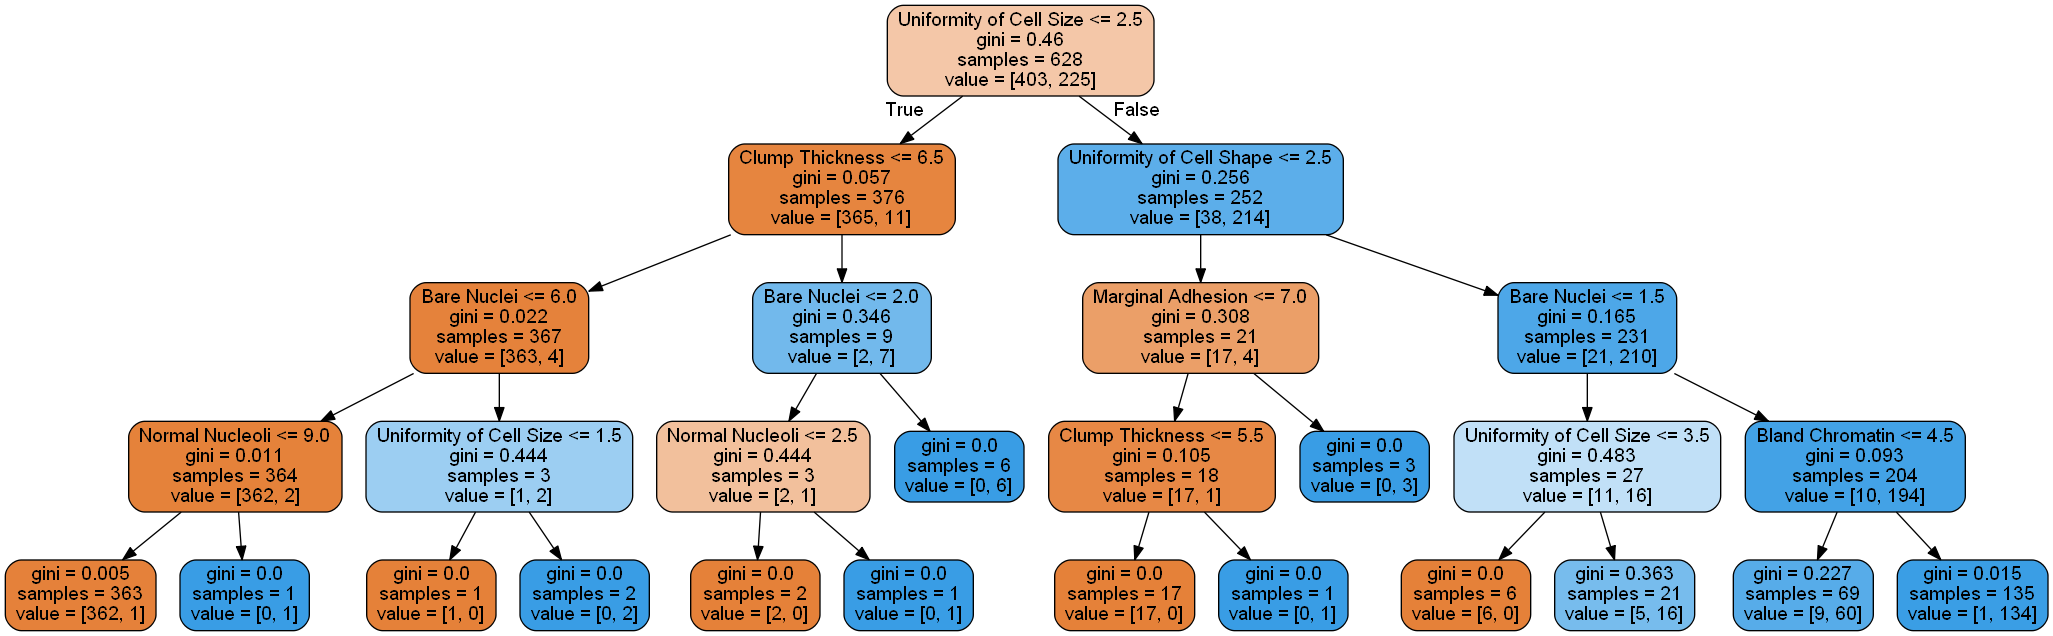

In [116]:
# Build and fit tree again using optimal hyperparameters
cancer_gin = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth = 4)
cancer_gin.fit(X_train, y_train)

# Display tree
show_tree('entropy_tree', cancer_gin, X_train.columns)

The gini method selects features in the order:

1. Criterion 1: 'Uniformity of Cell Size'
1. Criterion 2: 'Clump Thickness' or 'Uniformity of Cell Shape'
1. Criterion 3: 'Bare Nuclei' or 'Marginal Adhesion'
1. Criterion 4: 'Normal Nucleoli', 'Uniformity of Cell Size', 'Clump Thickness', or 'Bland Chromatin'

It is clear that the gini method considers a larger number of features at each level of the tree, which seems to explain its higher level of recall.

## 4. Determine the AUC for the best model you can achieve
In this section we determine the AUC for the best model we can achieve. We inquire as to the precision and recal values and as to which might be the one we want to maximize.

## 5. Implications of using this type of machine learning algorithm for breast cancer analysis
Here we examine the implications of using this type of machine learning algorithm for breast cancer analysis.